In [27]:
import awkward as ak
from coffea import nanoevents
from coffea.nanoevents.methods.base import NanoEventsArray

# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import pickle
import matplotlib.pyplot as plt
import numpy as np

from typing import Optional, List, Dict
from copy import copy

import mplhep as hep
from matplotlib import colors
from tqdm import tqdm
import uproot

import jetnet

In [46]:
nanoevents.NanoAODSchema.nested_index_items["FatJetAK15_pFCandsIdxG"] = (
    "FatJetAK15_nConstituents",
    "JetPFCandsAK15",
)
nanoevents.NanoAODSchema.mixins["FatJetAK15"] = "FatJet"
nanoevents.NanoAODSchema.mixins["PFCands"] = "PFCand"

events = nanoevents.NanoEventsFactory.from_root(
    "../../../../data/2017_UL_nano/GluGluHToWWTo4q_M-125_TuneCP5/nano_mc_2017_ULv1_NANO_100.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1915 branches) at 0x000160e47d30>, taking first instance
  warnings.warn(
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1915 branches) at 0x000160e47d30>, taking first instance
  warnings.warn(
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1915 branches) at 0x000160e47d30>, taking first instance
  warnings.warn(
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (1915 branches) at 0x000160e47d30>, taking first instance
  war

In [29]:
events = uproot.concatenate("../../../../../hwwtagger/sample_data/tagger_input_outs/GluGluToHHTobbVV_node_cHHH1/*.root:Events")


In [3]:
events

<NanoEventsArray [<event 1:922:92106>, ... ] type='1200 * event'>

In [30]:
events.fields

['fj_H_VV_4q',
 'fj_H_VV_elenuqq',
 'fj_H_VV_munuqq',
 'fj_H_VV_taunuqq',
 'fj_H_VV_unmatched',
 'fj_PN_XbbvsQCD',
 'fj_dR_V',
 'fj_dR_Vstar',
 'fj_eta',
 'fj_genRes_eta',
 'fj_genRes_mass',
 'fj_genRes_phi',
 'fj_genRes_pt',
 'fj_genV_eta',
 'fj_genV_mass',
 'fj_genV_phi',
 'fj_genV_pt',
 'fj_genVstar_eta',
 'fj_genVstar_mass',
 'fj_genVstar_phi',
 'fj_genVstar_pt',
 'fj_genX_eta',
 'fj_genX_mass',
 'fj_genX_phi',
 'fj_genX_pt',
 'fj_genjetmass',
 'fj_genjetmsd',
 'fj_isQCDb',
 'fj_isQCDbb',
 'fj_isQCDc',
 'fj_isQCDcc',
 'fj_isQCDlep',
 'fj_isQCDothers',
 'fj_mass',
 'fj_msoftdrop',
 'fj_nprongs',
 'fj_phi',
 'fj_pt',
 'pfcand_VTX_ass',
 'pfcand_abseta',
 'pfcand_charge',
 'pfcand_dxy',
 'pfcand_dxysig',
 'pfcand_dz',
 'pfcand_dzsig',
 'pfcand_e_log_nopuppi',
 'pfcand_etarel',
 'pfcand_isChargedHad',
 'pfcand_isEl',
 'pfcand_isGamma',
 'pfcand_isMu',
 'pfcand_isNeutralHad',
 'pfcand_lostInnerHits',
 'pfcand_mask',
 'pfcand_normchi2',
 'pfcand_phirel',
 'pfcand_pt_log_nopuppi',
 'pfcan

In [15]:
events.GenPart[0].pdgId.to_numpy()

array([ 21,  21,  25,  21,  25,  25,  25,  25,  24, -24, -24,  22,  24,
        -1,   2,   1,  -2,   1,  -2,   2,  -1,  21,  21,  21,  21,  21,
        21,  21,  21], dtype=int32)

In [34]:
events[i]

<Record ... 2.37, 0.233, 0.197, -0.596, 0, 0]} type='{"fj_H_VV_4q": 1 * int32, "...'>

[0.0239]
[-0.0291]
[-0.14]
[-0.0213]
[0.0562]
[0.05]
[-0.264]
[-0.323]
[0.0564]
[-0.0828]
[0.0564]
[-0.0828]
[-0.339]
[-0.134]
[-0.339]
[-0.134]
[-0.147]
[-0.211]
[0.0869]
[0.317]
[-0.501]
[-0.31]
[-0.501]
[-0.31]


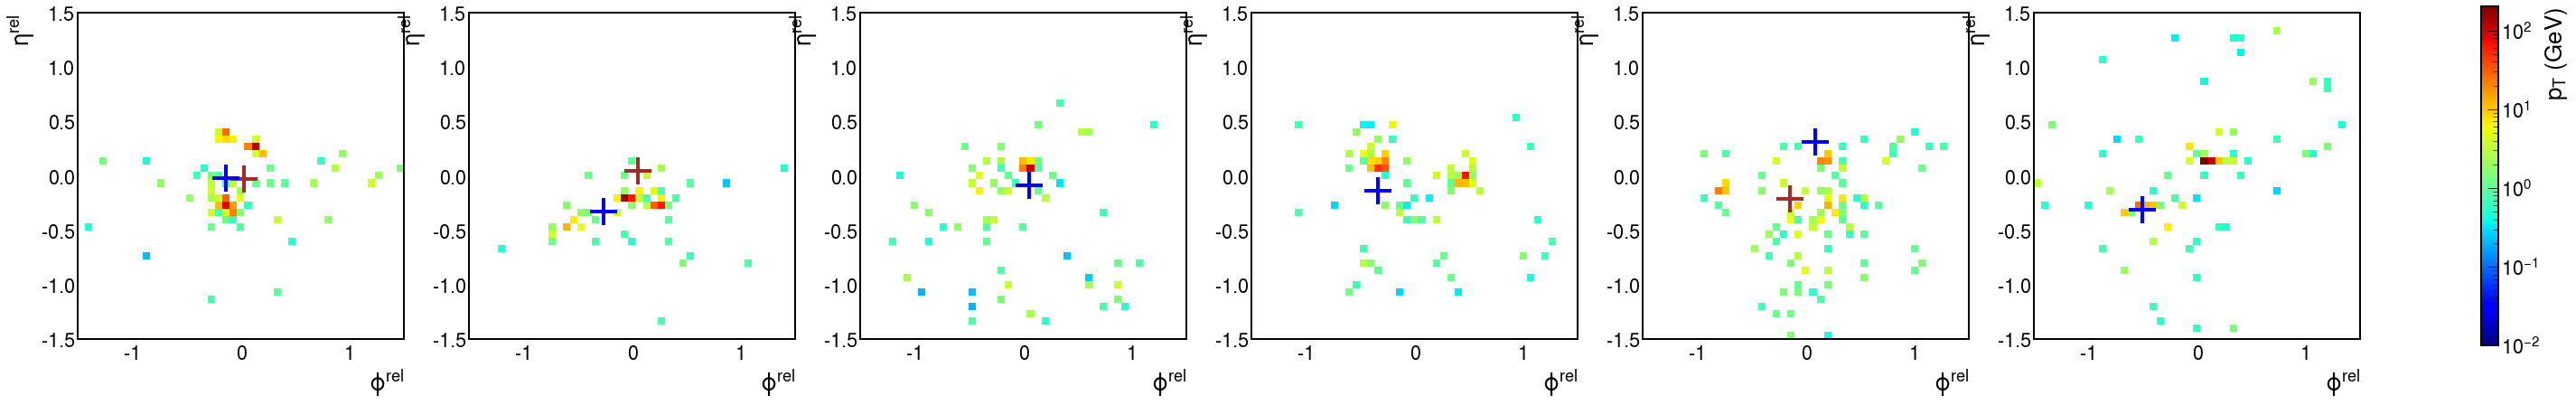

In [45]:
average_images = {}

cm = copy(plt.cm.jet)
cm.set_under(color="white")

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)


maxR = 1.5
im_size = 45


def del_phi(a, b):
    return (a - b + np.pi) % (2 * np.pi) - np.pi


def event_to_image(event, maxR, im_size):
    num_parts = np.sum(event["pfcand_etarel"] != 0)
    return jetnet.utils.to_image(
        np.vstack(
            (
                event["pfcand_etarel"].to_numpy()[:num_parts],
                event["pfcand_phirel"].to_numpy()[:num_parts],
                np.exp(event["pfcand_pt_log_nopuppi"].to_numpy()[:num_parts]),
            )
        ).T,
        im_size,
        maxR=maxR,
    ).T


num_images = 6

vmin = 1e-2
vmax = 200

fig, axes = plt.subplots(1, num_images, figsize=(num_images*8, 8))

for i in range(num_images):
    im = axes[i].imshow(
        event_to_image(events[i], maxR=maxR, im_size=im_size),
        cmap=cm,
        interpolation="nearest",
        extent=[-maxR, maxR, -maxR, maxR],
        norm=colors.LogNorm(vmin, vmax),
    )
    # plot Ws
    axes[i].plot(
        del_phi(events[i]["fj_genV_phi"], events[i]["fj_phi"]),
        events[i]["fj_genV_eta"] - events[i]["fj_eta"],
        "+",
        color="brown",
        ms=30,
        mew=4,
    )
    print(del_phi(events[i]["fj_genV_phi"], events[i]["fj_phi"]))
    print(events[i]["fj_genV_eta"] - events[i]["fj_eta"])
    axes[i].plot(
        del_phi(events[i]["fj_genVstar_phi"], events[i]["fj_phi"]),
        events[i]["fj_genVstar_eta"] - events[i]["fj_eta"],
        "b+",
        ms=30,
        mew=4,
    )
    print(del_phi(events[i]["fj_genVstar_phi"], events[i]["fj_phi"]))
    print(events[i]["fj_genVstar_eta"] - events[i]["fj_eta"])
    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.007)
cbar.set_label("$p_T$ (GeV)")

# fig.tight_layout()
# plt.savefig(f"{plot_dir}/jet_images_qcd.pdf", bbox_inches="tight")
plt.show()

In [39]:
events[i]["fj_genV_phi"]

<Array [-0.116] type='1 * float64'>

In [40]:
events[i]["fj_phi"]

<Array [0.385] type='1 * float64'>

In [41]:
events[i]["fj_genV_eta"]

<Array [-1.68] type='1 * float64'>

In [42]:
events[i]["fj_eta"]

<Array [-1.37] type='1 * float64'>